# Permutation Testing

Permutation tests (exact tests) allow to check how likely it is that two samples are obtained from the same distribution. This can be very handy in A/B testing.
The hypothesis H1 is that the two samples are drawn from two distribution not having the same mean value, while the alternative hypothesis H0 is that were drawn from the same distribution (i.e. distributions which have the same mean value).

Given H0 is true, we can swap data between both samples and the test statistic should not change drastically.
This is some form of resampling.
Then we can compute a statistic measuring for example the difference of mean values or standard devations between the samples.
We can then look at the distribution of resampled statistics and compare the original statistic to it.
Additionally, we can even compute the p-value using the cumulative distribution function of the resampled statistics.

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import copy

plt.rcParams["figure.figsize"] = [10, 5]

samples_A = np.random.normal(size=100)
samples_B = np.random.normal(loc=0.2, size=100)

# also try this to see a clear rejection of the null hypothesis
# samples_B = np.random.normal(loc=0.5, size=100)
# or try
# samples_B = np.random.uniform(size=100)


def difference_of_mean_values(samples_A, samples_B):
    return np.mean(samples_A) - np.mean(samples_B)


original_statistic = difference_of_mean_values(samples_A, samples_B)


def generate_permutation(samples_A, samples_B):
    samples_A = copy.deepcopy(samples_A)
    samples_B = copy.deepcopy(samples_B)
    for num_i in range(max(len(samples_A), len(samples_B))):
        index_B_replacement = np.random.randint(low=0, high=len(samples_B))
        index_A_replacement = np.random.randint(low=0, high=len(samples_A))
        temp = samples_B[index_B_replacement]
        samples_B[index_B_replacement] = samples_A[index_A_replacement]
        samples_A[index_A_replacement] = temp
    return samples_A, samples_B


NUM_PERMUTATIONS = 2000
permutated_samples = [
    generate_permutation(samples_A, samples_B) for i in range(NUM_PERMUTATIONS)
]


statistic_values = [
    difference_of_mean_values(*permutated_samples[i]) for i in range(NUM_PERMUTATIONS)
]

Next we plot the distribution of the difference statistic and answer the question: "How probable is it (given the null hypothesis) that we obtain a statistic as extreme as the one originally reported?"
For this we need to compute the probability of obtaining a result as extreme (in absolute value) as the originally reported one -- this is the two sided p value. We do this via the empirical cumulative distribution function obtained from the histogram of the statistic (under the null hypothesis) and integrate the (empirical) probability density function in the black areas.

Two sided pvalue 0.06683761546995225


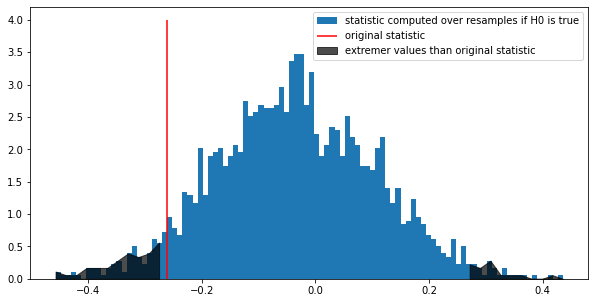

In [28]:
import scipy.stats

hist = np.histogram(statistic_values, bins=100, density=True)
hist_dist = scipy.stats.rv_histogram(hist)

probabilitity_smaller_than_abs_original_statistic = hist_dist.cdf(
    -abs(original_statistic)
)
probabilitity_bigger_than_abs_original_statistic = 1 - hist_dist.cdf(
    abs(original_statistic)
)
two_sided_p_value = (
    probabilitity_smaller_than_abs_original_statistic
    + probabilitity_bigger_than_abs_original_statistic
)


# cap computed p value to 1/NUM_PERMUTATIONS
two_sided_p_value = max(two_sided_p_value, 1.0 / float(NUM_PERMUTATIONS))

plt.hist(
    statistic_values,
    bins=100,
    label="statistic computed over resamples if H0 is true",
    density=True,
)
x_values = np.linspace(np.min(statistic_values), np.max(statistic_values))
pdf_values = hist_dist.pdf(x_values)
plt.vlines(original_statistic, 0, 4, color="red", label="original statistic")

plt.fill_between(
    x_values,
    pdf_values,
    where=x_values <= -abs(original_statistic),
    color="black",
    zorder=2,
    alpha=0.7,
)
plt.fill_between(
    x_values,
    pdf_values,
    where=x_values >= abs(original_statistic),
    color="black",
    zorder=2,
    alpha=0.7,
    label="extremer values than original statistic",
)
plt.legend()
print(f"Two sided pvalue {two_sided_p_value}")

In [29]:
# When the null hypothesis is actually true, the significance niveau says that the test may at most be rejected
# in the fraction alpha of the cases.
# Alpha is, therefore, a limit for the false positive rate.
# Note that repeated testing with N many datasets can give alpha*N many false positive discoveries seeming
# significant because they have a smaller p value than alpha (which is called p-Hacking).
# The False negative (FN) error beta is controlled by the statistical power.
significance_niveau_alpha = 0.01
if two_sided_p_value < significance_niveau_alpha:
    print(
        f"\
          The p value indicates that the samples are from two different distributions. \n\
          The probability that the null hypothesis is correct is {two_sided_p_value}"
    )
else:
    print(
        f"\
          The p value does not support rejecting the null hypothesis. \n\
          The samples could come from distributions having the same mean. \n\
          Under the null hypothesis pvalue*100 percent many values are as extreme\n\
          or more extreme than the originally computed statistic on the samples A and B.\n\
          The p value is too high: {two_sided_p_value}\
          "
    )

          The p value does not support rejecting the null hypothesis. 
          The samples could come from distributions having the same mean. 
          Under the null hypothesis pvalue*100 percent many values are as extreme
          or more extreme than the originally computed statistic on the samples A and B.
          The p value is too high: 0.06683761546995225          


# Statistical Power (TPR of rejecting equality)

Next we compute the statistical power (for a given true difference in mean $\mathrm{true shift}$ and significance niveau ...). The significance niveau of the test allows to assess the false negative rate (beta). Beta is the probability of making a type 2 error, i.e. false negatives (rejecting H1 although it is true).

In [4]:
def is_not_equal(samples_A, samples_B, NUM_PERMUTATIONS=120):
    # this function tests whether the test for equality should be rejected
    # the null hypothesis is that A and B have the same mean
    original_statistic = difference_of_mean_values(samples_A, samples_B)

    statistic_values = [
        difference_of_mean_values(*generate_permutation(samples_A, samples_B))
        for i in range(NUM_PERMUTATIONS)
    ]

    hist = np.histogram(statistic_values, bins=100, density=True)
    hist_dist = scipy.stats.rv_histogram(hist)

    probabilitity_smaller_than_abs_original_statistic = hist_dist.cdf(
        -abs(original_statistic)
    )
    probabilitity_bigger_than_abs_original_statistic = 1 - hist_dist.cdf(
        abs(original_statistic)
    )
    two_sided_p_value = (
        probabilitity_smaller_than_abs_original_statistic
        + probabilitity_bigger_than_abs_original_statistic
    )

    # cap computed p value to 1/NUM_PERMUTATIONS
    two_sided_p_value = max(two_sided_p_value, 1.0 / float(NUM_PERMUTATIONS))

    significance_niveau_alpha = 0.01
    if two_sided_p_value < significance_niveau_alpha:
        # samples A and B do not have same mean: p is low, then null must go
        return True
    else:
        # samples A and B have same mean
        return False

In [5]:
NUM_TESTS = 100
true_shift = 0.4

rejections_equality = []
for i in range(NUM_TESTS):
    rejections_equality.append(
        is_not_equal(
            np.random.normal(size=100), np.random.normal(loc=true_shift, size=100)
        )
    )

true_positive_rate = np.average(rejections_equality)
print(
    "Power of test (low is bad): True positive rate for rejecting equality (at the given significance niveau, and shift): 1-beta =",
    true_positive_rate,
)
false_negative_rate = 1 - true_positive_rate
print(
    "Detecting no differences: False negative rate for rejecting equality is beta = ",
    false_negative_rate,
)

Power of test (low is bad): True positive rate for rejecting equality (at the given significance niveau, and shift): 1-beta = 0.56
Detecting no differences: False negative rate for rejecting equality is beta =  0.43999999999999995


# Significance Niveau (FPR of rejecting equality) 

In [26]:
NUM_TESTS = 400  # in order to have a chance of estimating the true alpha for our test,
# we need at least 2/significance_niveau_alpha
true_shift = (
    0.0  # Important: with shift 0.0 both samples come from the same distribution
)

rejections_equality = []
for i in range(NUM_TESTS):
    rejections_equality.append(
        is_not_equal(
            np.random.normal(size=100), np.random.normal(loc=true_shift, size=100)
        )
    )
false_positive_rate = np.average(rejections_equality)
false_positive_rate_CI = (
    1.96 * np.std(rejections_equality, ddof=1) / np.sqrt(NUM_TESTS)
)  # Wald confidence interval
print(
    f"\
    False positive rate for rejecting equality (at the given significance niveau, and shift): \n\
    alpha = {false_positive_rate} +/-{false_positive_rate_CI}"
)
print(
    f"\
    Detecting no differences: True negative rate for rejection is 1-alpha = {1-false_positive_rate} +/-{false_positive_rate_CI}"
)

    False positive rate for rejecting equality (at the given significance niveau, and shift): 
    alpha = 0.02142857142857143 +/-0.010735205409918017
    Detecting no differences: True negative rate for rejection is 1-alpha = 0.9785714285714285 +/-0.010735205409918017
